In [14]:
import numpy as np
import json
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import time
from PIL import Image
from pc_to_xml import pc_to_xml

In [2]:
image_data = np.load('partial_image_data_160_240.npy')
with open('partial_extra_data_160_240.json') as f:
    extra_data = json.load(f)

In [3]:
# lexicon = list(set([x for y in extra_data for x in y['pc']]))
# lexicon = lexicon + ['<PAD>']
lexicon = ['6', '<START>', '12', '7', 'rest', 'pitch', '3', 'E', '}', 'quarter', '2', '16', '4', 'C', 'measure', '<END>', '0', 'staff', 'duration', 'G', 'chord', 'D', '5', 'F', 'B', 'note', 'backup', 'type', 'A', '-1', '1', '<PAD>']
print(lexicon)
word_to_ix = {word: ix for ix, word in enumerate(lexicon)}
ix_to_word = {ix: word for ix, word in enumerate(lexicon)}

['6', '<START>', '12', '7', 'rest', 'pitch', '3', 'E', '}', 'quarter', '2', '16', '4', 'C', 'measure', '<END>', '0', 'staff', 'duration', 'G', 'chord', 'D', '5', 'F', 'B', 'note', 'backup', 'type', 'A', '-1', '1', '<PAD>']


In [4]:
batch_size = 128
seq_len = 64

In [5]:
# augment image data to include key and time signature info
aug = []
for i in range(len(extra_data)):
    measure_length = extra_data[i]['measure_length']
    key_number = extra_data[i]['key_number']
    key_number += 7
    vec = np.zeros((2, 20))
    vec[0, key_number] += 1
    if measure_length == 12:
        vec[1, 0] += 1
    elif measure_length == 16:
        vec[1, 1] += 1
    tiled = np.tile(vec, (80, 12))
    aug.append(tiled)
aug = np.array(aug)
aug = aug.reshape(-1, 1, 160, 240)
print(aug.shape)

(7153, 1, 160, 240)


In [6]:
language_data = dict()

language_samples = []
image_indices = []
for image_index, datum in enumerate(extra_data):
    pc = ['<PAD>'] *seq_len + datum['pc'] + ['<PAD>']*seq_len
    for i in range(len(pc)-seq_len-1):
        seq = np.array([word_to_ix[word] for word in pc[i:i+seq_len]])
        target_seq = np.array([word_to_ix[word] for word in pc[i+1:i+seq_len+1]])
        language_samples.append(np.array([seq, target_seq]))
        image_indices.append(image_index)

language_samples = np.array(language_samples)
image_indices = np.array(image_indices)
language_data[seq_len] = (language_samples, image_indices)
    
image_data = image_data.reshape(-1, 1, 160, 240)
image_data = np.concatenate([image_data, aug], axis=1)
print(image_data.shape)

(7153, 2, 160, 240)


In [7]:
epoch_lengths = dict()
epoch_lengths[seq_len] = int(language_data[seq_len][0].shape[0]/batch_size)
print(epoch_lengths[seq_len])

11839


In [4]:
class ConvUnit(nn.Module):
    def __init__(self, input_size, output_size, filter_size, stride, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv2d(input_size, output_size, filter_size, stride=1, padding=padding)
        self.dp1 = nn.Dropout2d(p=dropout)
        self.bn1 = nn.BatchNorm2d(output_size)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(output_size, output_size, filter_size, stride=stride, padding=padding)
        self.dp2 = nn.Dropout2d(p=dropout)
        self.bn2 = nn.BatchNorm2d(output_size)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        x = self.relu1(self.bn1(self.dp1(self.conv1(x))))
        x = self.relu2(self.bn2(self.dp2(self.conv2(x))))
        return x


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(ConvUnit(2, 64, 3, 2, 1, 0.25), # (160, 240) --> (80, 120)
                                 ConvUnit(64, 128, 3, 2, 1, 0.25), # (80, 120) --> (40, 60)
                                 ConvUnit(128, 128, 3, 4, 1, 0.25), # (40, 60) --> (10, 15)
                                 ConvUnit(128, 128, 3, 5, 1, 0.25)) # (10, 15) --> (2, 3)
        self.fc1 = nn.Linear(768, 256)
        self.embed = nn.Embedding(num_embeddings=len(lexicon), embedding_dim=5)
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=256, num_layers=2, batch_first=True, dropout=0.25)
        self.lstm2 = nn.LSTM(input_size=256+256, hidden_size=256, num_layers=2, batch_first=True, dropout=0.25)
        self.fc2 = nn.Linear(256, len(lexicon))
        
    def forward(self, image_input, language_input, internal1=None, internal2=None):
        bs = image_input.shape[0]
        seq_len = language_input.shape[1]
        if internal1:
            h1, c1 = internal1
        else:
            h1 = torch.zeros(2, bs, 256).cuda()
            c1 = torch.zeros(2, bs, 256).cuda()
        if internal2:
            h2, c2 = internal2
        else:
            h2 = torch.zeros(2, bs, 256).cuda()
            c2 = torch.zeros(2, bs, 256).cuda()
        image_output = self.fc1(self.cnn(image_input).view(bs, 768))
        image_output = image_output.repeat(1, seq_len).view(bs, seq_len, 256)
        language_output, (h1, c1) = self.lstm1(self.embed(language_input), (h1, c1))
        concatenated = torch.cat([image_output, language_output], 2)
        lstm2_out, (h2, c2) = self.lstm2(concatenated, (h2, c2))
        out = self.fc2(lstm2_out)
        return out, (h1, c1), (h2, c2)
    
    def fit(self, image_data, language_data, optimizer, loss_fn, num_iterations, seq_len, rate_decay):
        t = time.time()
        for i in range(num_iterations):
            self.train()
            X = language_data[0][:, 0, :]
            y = language_data[0][:, 1, :]
            image_indices = language_data[1]
            batch_indices = np.random.choice(X.shape[0], size=batch_size)
            x = torch.Tensor(X[batch_indices]).type(torch.long).cuda()
            targets = torch.Tensor(y[batch_indices]).type(torch.long).cuda()
            image_batch = torch.Tensor(image_data[image_indices[batch_indices]]).type(torch.float).cuda()
            out, _, _ = self.forward(image_batch, x)
            out = out.view(batch_size*seq_len, len(lexicon))
            targets = targets.view(batch_size*seq_len)
            loss = loss_fn(out, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if i % 100 == 0:
                n = np.random.choice(image_data.shape[0])
                prediction = self.predict(image_data[n])
                print(f'iteration: {i}, loss: {loss}, seconds elapsed: {time.time() - t}')
                print('predicted : ' + prediction)
                print('true      : ' + ' '.join(extra_data[n]['pc']))
                print('---------------------------')
                with open('storage/measure_model_quarters_log_file-2019-09-20.txt', 'a+') as f:
                    f.write(f'iteration: {i}, loss: {loss}, seconds elapsed: {time.time()-t}\n')
                    f.write('predicted :  ' + prediction + '\n')
                    f.write('true      :  ' + ' '.join(extra_data[n]['pc']) + '\n')
                    f.write('------------------------------\n')
                    
            if i % 5000 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= rate_decay
                torch.save(model, f'storage/measure_model_quarters_iteration_{i}_2019-09-20.pt')

                
             
    def predict(self, image):
        self.eval()    
        with torch.no_grad():
            image = torch.Tensor(image).type(torch.float).view(1, 2, 160, 240).cuda()
            output_sequence = ['<START>']
            h1 = torch.zeros(2, 1, 256).cuda()
            c1 = torch.zeros(2, 1, 256).cuda()
            h2 = torch.zeros(2, 1, 256).cuda()
            c2 = torch.zeros(2, 1, 256).cuda()
            while output_sequence[-1] != '<END>' and len(output_sequence)<300:
                language_input = torch.Tensor([word_to_ix[output_sequence[-1]]]).type(torch.long).view(1, 1).cuda()
                out, (h1, c1), (h2, c2) = self.forward(image, language_input, (h1, c1), (h2, c2))
                _, language_input = out[0, 0, :].max(0)
                output_sequence.append(ix_to_word[language_input.item()])
        self.train()
        return ' '.join(output_sequence)

In [21]:
# model = Net().cuda()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# loss_fn = nn.CrossEntropyLoss()

In [ ]:
# model.fit(image_data, language_data[seq_len], optimizer, loss_fn, 50001, seq_len, 0.92)

iteration: 0, loss: 3.4669435024261475, seconds elapsed: 1.0953397750854492
predicted : <START> 7 7 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
true     

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvUnit. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


iteration: 100, loss: 2.1632049083709717, seconds elapsed: 46.377636671066284
predicted : <START> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

In [5]:
model = torch.load('measure_model_quarters_iteration_45000_2019-09-20.pt')

c:\users\kjdma\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\users\kjdma\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\users\kjdma\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has

In [22]:
from pc_to_xml import pc_to_xml
n = 59
pc_pred = model.predict(image_data[n]).split()[1:-1]
pc_true = extra_data[n]['pc'][1:-1]
measure_length = extra_data[n]['measure_length']
key_number = extra_data[n]['key_number']
with open('prediction.musicxml', 'w+') as f:
    f.write(str(pc_to_xml(pc_pred, measure_length, key_number)))
with open('true.musicxml', 'w+') as f:
    f.write(str(pc_to_xml(pc_true, measure_length, key_number)))

In [68]:
n = 77
image_np = image_data[n, 0, :, :]
image_np = 255-image_np
image = Image.fromarray(image_np)
image = image.convert('RGB')
image.save('sample_image2.png')

In [10]:
def create_aug_array(measure_length, key_number):
    key_number += 7
    vec = np.zeros((2, 20))
    vec[0, key_number] += 1
    if measure_length == 12:
        vec[1, 0] += 1
    elif measure_length == 16:
        vec[1, 1] += 1
    tiled = np.tile(vec, (80, 12))
    return tiled

In [11]:
def rgb_to_grayscale(x):
    # x is an numpy array with shape (a, b, 3)
    a, b, _ = x.shape
    weights = np.array([[0.2125, 0.7154, 0.0721]]).T
    return (x @ weights).reshape(a, b)

In [15]:
def predict_from_image_file(path, measure_length, key_number):
    image = Image.open(path)
    image = image.resize((240, 160))
    image_np = np.array(image)[:, :, :3]
    image_np = rgb_to_grayscale(image_np)
    plt.imshow(image_np, cmap='bone')
    image_np = np.array([image_np, create_aug_array(measure_length, key_number)])
    image_np = image_np.reshape(1, 2, 160, 240)
    pc_pred_str = model.predict(image_np)
    pc_pred = pc_pred_str.split()[1:-1]
    xml_pred = pc_to_xml(pc_pred, measure_length, key_number)
    with open('pred.musicxml', 'w+') as f:
        f.write(str(xml_pred))
    return xml_pred

TypeError: cannot unpack non-iterable NoneType object

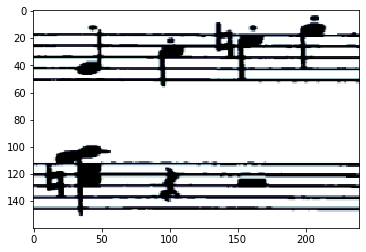

In [16]:
predict_from_image_file('Beethoven_Clean.PNG', 16, -4)

<?xml version="1.0" encoding="utf-8"?>
<score-partwise version="3.1"><part-list><score-part id="P1"><part-name>Piano</part-name></score-part></part-list><part id="P1"><measure number="1"><attributes><divisions>4</divisions><key><fifths>0</fifths></key><time><beats>4</beats><beat-type>4</beat-type></time><staves>2</staves><clef number="1"><sign>G</sign><line>2</line></clef><clef number="2"><sign>F</sign><line>4</line></clef></attributes><note><pitch><step>G</step><octave>4</octave></pitch><duration>4</duration><type>quarter</type><staff>1</staff></note><note><pitch><step>B</step><octave>4</octave></pitch><duration>4</duration><type>quarter</type><staff>1</staff></note><note><chord></chord><pitch><step>F</step><octave>4</octave></pitch><duration>4</duration><type>quarter</type><staff>1</staff></note><note><pitch><step>E</step><octave>5</octave></pitch><duration>4</duration><type>quarter</type><staff>1</staff></note><note><pitch><step>E</step><octave>5</octave></pitch><duration>4</duratio

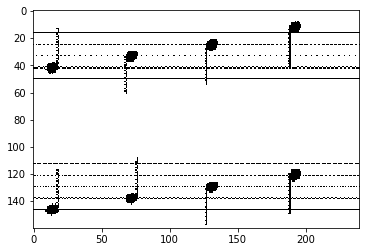

In [107]:
print(predict_from_image_file('gutenberg_sample.png', 16, 0))

TypeError: cannot unpack non-iterable NoneType object

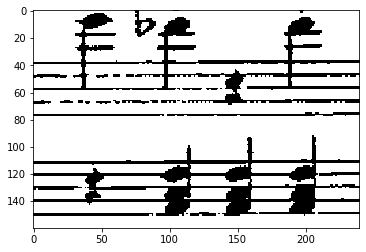

In [93]:
from scipy.ndimage import median_filter

image = Image.open('Beethoven_Tinted.PNG')
image = image.resize((240, 160))
image = image.convert('1')
image_np = np.array(image).astype(np.uint8)
image_np *= 255
image_np = 255 - image_np
image_np = median_filter(image_np, 2)
plt.imshow(image_np, cmap='bone_r')
image_np = np.array([image_np, create_aug_array(measure_length, key_number)])
image_np = image_np.reshape(1, 2, 160, 240)
pc_pred_str = model.predict(image_np)
pc_pred = pc_pred_str.split()[1:-1]
xml_pred = pc_to_xml(pc_pred, measure_length, key_number)